In [1]:
import pandas as pd
from torch.utils.data import Dataset
import torch

# Define the SMILES for each base polymer type.
polymer_smiles = {
    "PET": "[*]OCCOC(=O)c1ccc(cc1)C(=O)O[*]",
    "PU": "[*]OCCOC(=O)NCCCCCCN(=O)OCCO[*]",
    "PCL": "[*]OCCCCC(=O)[*]",
    "PLA": "[*]OC(C)C(=O)[*]",
    "PES": "[*]OCCOC(=O)CC(=O)O[*]",
    "PEF": "[*]OCCOC(=O)c1ccoc1C(=O)O[*]",
    "PE": "[*]CC[*]",
    "PHB": "[*]OC(C)CC(=O)[*]",
    "PHV": "[*]OC(C)CCC(=O)[*]",
    "PBS": "[*]OCCCCOC(=O)CC(=O)O[*]",
    "PBSA": "[*]OCCCCOC(=O)CC(=O)O[*]",
    "PVA": "CCO",              # Example for PVA
    "PEG": "OCCO",             # Example for PEG
    "Nylon": "NCCCCNCCCC(=O)O"  # Example for Nylon-6,6
}

def get_smiles(plastic_type):
    """
    Given a plastic type string, return a SMILES string.
    For composite types (containing underscores), split them and map each component,
    then join the resulting SMILES with a period.
    For example, "PHB_PHA" is split into ["PHB", "PHA"]. If “PHA” is not in the base
    dictionary, we assume it can be mapped to "PHB" (i.e. use the same SMILES).
    """
    if not isinstance(plastic_type, str):
        return None

    # If the plastic type contains an underscore, it is composite.
    if "_" in plastic_type:
        parts = plastic_type.split("_")
        smiles_list = []
        for part in parts:
            part = part.strip()
            if part in polymer_smiles:
                smiles_list.append(polymer_smiles[part])
            else:
                # Handle some known alternative names:
                # If the sub-part is "PHA" or "PHO", assume it should use "PHB".
                if part in ["PHA", "PHO"]:
                    smiles = polymer_smiles.get("PHB", None)
                    if smiles:
                        smiles_list.append(smiles)
                # Otherwise, you might choose to warn or skip.
        if smiles_list:
            # Join the SMILES with a dot to indicate a composite structure.
            return ".".join(smiles_list)
        else:
            return None
    else:
        # Single plastic type: try a direct lookup.
        part = plastic_type.strip()
        if part in polymer_smiles:
            return polymer_smiles[part]
        # Handle alternatives: for example, if the type is "PHA" or "PHO"
        if part in ["PHA", "PHO"]:
            return polymer_smiles.get("PHB", None)
        return None

def preprocess_snp_data(file_path):
    # Load your CSV file.
    df = pd.read_csv(file_path)

    # Drop any columns that have "SMILES" in their name.
    cols_to_drop = [col for col in df.columns if "SMILES" in col]
    if cols_to_drop:
        df = df.drop(columns=cols_to_drop)

    # Ensure the CSV has a "Plastic Type" column.
    if "Plastic Type" not in df.columns:
        raise KeyError("Expected a 'Plastic Type' column in your CSV.")

    # Create a new "smiles" column using our mapping function.
    df["smiles"] = df["Plastic Type"].apply(get_smiles)

    # Check and print the number of rows that did not get a valid SMILES.
    num_na = df["smiles"].isna().sum()
    print(f"Number of rows with missing SMILES: {num_na}")

    # Drop rows without a defined SMILES.
    df = df[df["smiles"].notna()].copy()

    # Rename the enzyme sequence column "AA Seq" to "protein_sequence" if present.
    if "AA Seq" in df.columns:
        df.rename(columns={"AA Seq": "protein_sequence"}, inplace=True)

    # Compute string lengths for later filtering.
    df["smiles_length"] = df["smiles"].apply(len)
    df["protein_length"] = df["protein_sequence"].apply(len)

    # At this point, df will have at least:
    # - "Plastic Type"
    # - "protein_sequence"
    # - "smiles"
    return df

def filter_datasets(dataset):
    return dataset[
        (dataset["smiles"].notna()) &
        (dataset["protein_sequence"].notna()) &
        (dataset["smiles_length"] > 0) &
        (dataset["protein_length"] > 0)
    ]

# Dataset class and collate function remain as before.
class ProteinGenerationDataset(Dataset):
    def __init__(self, dataframe, max_length):
        self.dataframe = dataframe
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        return row["smiles"], row["protein_sequence"]

def collate_fn(batch):
    """
    Custom collate function to handle padding within batches.
    Args:
        batch: List of tuples (smiles, protein_sequence)
    Returns:
        A dictionary containing the list of SMILES strings, padded protein sequences,
        and a protein mask tensor.
    """
    smiles, proteins = zip(*batch)
    smiles = list(smiles)

    # Determine max protein length in this batch (capped at 1024).
    max_protein_len = min(max(len(p) for p in proteins), 1024)

    padded_proteins = []
    protein_masks = []

    for protein in proteins:
        if len(protein) > max_protein_len:
            padded = protein[:max_protein_len]
            mask = [1] * max_protein_len
        else:
            padded = protein + " " * (max_protein_len - len(protein))
            mask = [1] * len(protein) + [0] * (max_protein_len - len(protein))
        padded_proteins.append(padded)
        protein_masks.append(mask)

    return {
        "smiles": smiles,
        "proteins": padded_proteins,
        "protein_masks": torch.tensor(protein_masks, dtype=torch.bool)
    }

# --- Example usage ---
csv_path = '/content/data-curation - Sheet1.csv'
df_preprocessed = preprocess_snp_data(csv_path)
df_filtered = filter_datasets(df_preprocessed)

Number of rows with missing SMILES: 42


In [2]:
df_filtered[["Plastic Type", "protein_sequence", "smiles"]].head()


,Plastic Type,protein_sequence,smiles
0,PHB_PHA,MKHPYGYRWHWLYALVVTLMTALATFSAHAAVTAGPGAWSSQQTWA...,[*]OC(C)CC(=O)[*].[*]OC(C)CC(=O)[*]
1,PHO_PHA,MPLRTLLCGLLLAVCLGQHALAASRCSERPRTLLRPAEVSCSYQST...,[*]OC(C)CC(=O)[*].[*]OC(C)CC(=O)[*]
2,PHB_PHA,MRNTLKAAFKLGVISAALLAPFATQAATAGPGAWSSQQTWAADSVN...,[*]OC(C)CC(=O)[*].[*]OC(C)CC(=O)[*]
3,PHB_PHA,MLAKQIKKANSRSTLLRKSLLFAAPIILAVSSSSVYALTQVSNFGT...,[*]OC(C)CC(=O)[*].[*]OC(C)CC(=O)[*]
4,PHB_PHA,MMSSQTTQSSKFSLFLKRGLLLAAAPLLAMSASSALAATQVTGFGS...,[*]OC(C)CC(=O)[*].[*]OC(C)CC(=O)[*]


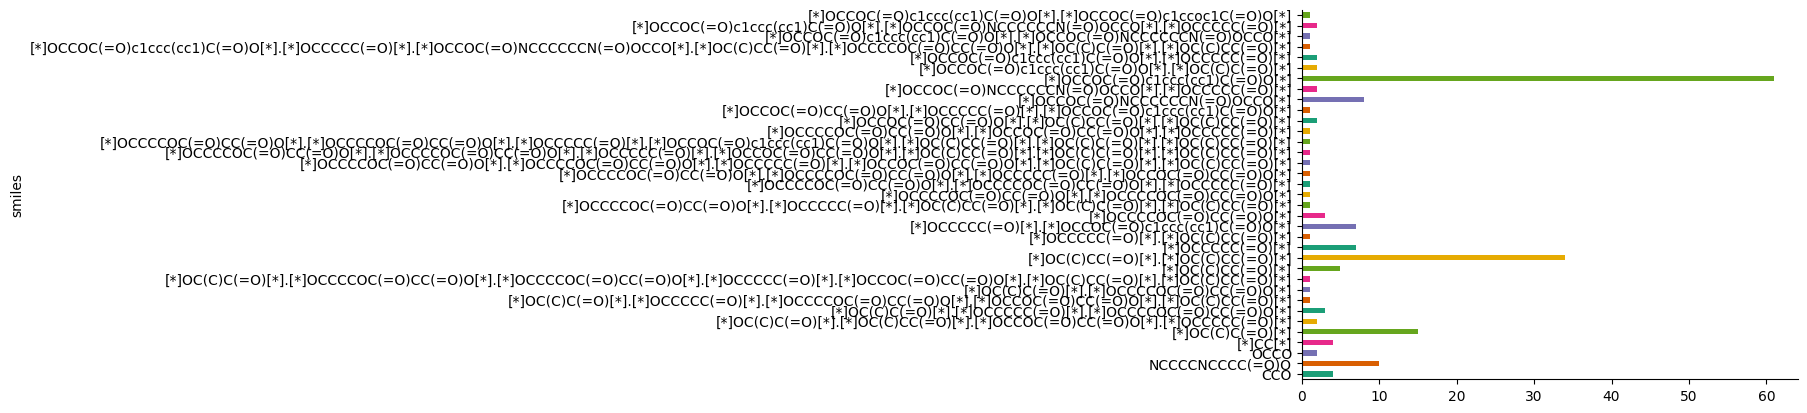

In [3]:

from matplotlib import pyplot as plt
import seaborn as sns
df_filtered.groupby('smiles').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

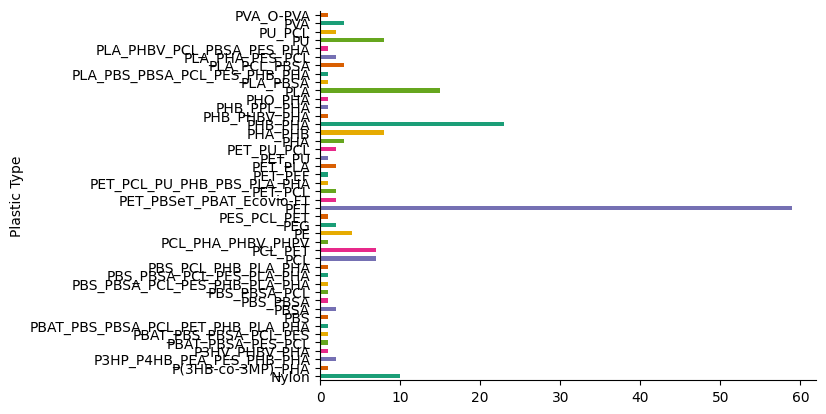

In [4]:
# @title Plastic Type

from matplotlib import pyplot as plt
import seaborn as sns
df_filtered.groupby('Plastic Type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [5]:
df_filtered

,Plastic Type,PDB-ID,Enzyme Name,protein_sequence,smiles,smiles_length,protein_length
0,PHB_PHA,NaN,PHB_depolymerase,MKHPYGYRWHWLYALVVTLMTALATFSAHAAVTAGPGAWSSQQTWA...,[*]OC(C)CC(=O)[*].[*]OC(C)CC(=O)[*],35,492
1,PHO_PHA,NaN,PHA_depolymerase,MPLRTLLCGLLLAVCLGQHALAASRCSERPRTLLRPAEVSCSYQST...,[*]OC(C)CC(=O)[*].[*]OC(C)CC(=O)[*],35,278
2,PHB_PHA,NaN,PHB_depolymerase-A,MRNTLKAAFKLGVISAALLAPFATQAATAGPGAWSSQQTWAADSVN...,[*]OC(C)CC(=O)[*].[*]OC(C)CC(=O)[*],35,433
3,PHB_PHA,NaN,PHB_depolymerase,MLAKQIKKANSRSTLLRKSLLFAAPIILAVSSSSVYALTQVSNFGT...,[*]OC(C)CC(=O)[*].[*]OC(C)CC(=O)[*],35,414
4,PHB_PHA,NaN,PHA_depolymerase_B,MMSSQTTQSSKFSLFLKRGLLLAAAPLLAMSASSALAATQVTGFGS...,[*]OC(C)CC(=O)[*].[*]OC(C)CC(=O)[*],35,433
...,...,...,...,...,...,...,...
224,PE,NaN,Manganese_Peroxidase_Iz-MnP1,MAFTSLLSLVALAAVARAAPAAETAVCPDGTRVSNSACCAFIPLAQ...,[*]CC[*],8,384
225,PE,NaN,Manganese_Peroxidase_Iz-MnP2,MALHLSSLLSASPRLHRAAPAAETAVCFDGTRVSNSACCAFIPLAQ...,[*]CC[*],8,385
226,PLA,NaN,poly(L-lacticacid)depolymerase,MKFGKFVLLAASTALAVVGLGGPAAADSTPQAQPSIIGGSNATSGP...,[*]OC(C)C(=O)[*],16,238
227,PLA,NaN,poly(L-lacticacid)depolymeraseC,MRMSRAVGAIGAAAAALSLVSAGVADAQQDIIGGTTVSSAPWGAQI...,[*]OC(C)C(=O)[*],16,234


In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import random
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
# Note: run !pip install fair-esm outside this class
import esm

class ProteinDataAugmenter:
    def __init__(self, df, seed=42, device="cpu"):
        self.df = df.copy()
        self.seed = seed
        self.device = device
        np.random.seed(seed)
        torch.manual_seed(seed)
        random.seed(seed)
        self.protein_embeddings = {}
        print("Loading ESM model...")
        self.esm_model, self.esm_alphabet = esm.pretrained.esm2_t33_650M_UR50D()
        self.esm_model = self.esm_model.eval().to(device)
        self.esm_batch_converter = self.esm_alphabet.get_batch_converter()

    def compute_protein_embeddings(self):
        print("Computing protein embeddings...")
        unique_proteins = self.df['protein_sequence'].unique()
        for protein in unique_proteins:
            if protein in self.protein_embeddings:
                continue
            data = [("protein", protein)]
            _, _, batch_tokens = self.esm_batch_converter(data)
            batch_tokens = batch_tokens.to(self.device)
            with torch.no_grad():
                results = self.esm_model(batch_tokens, repr_layers=[33], return_contacts=False)
            token_embeddings = results["representations"][33]
            protein_emb = token_embeddings[0, 1:len(protein)+1].cpu().numpy()
            # Store as tensor on the specified device
            self.protein_embeddings[protein] = torch.tensor(protein_emb, dtype=torch.float32, device=self.device)

    def perturb_embeddings(self, embeddings_dict, n_samples=5, sigma=0.1):
        perturbed_dict = {}
        for key, embedding in embeddings_dict.items():
            perturbed_embeddings = []
            for _ in range(n_samples):
                # Create noise directly on the same device as the embedding
                noise = torch.randn_like(embedding) * sigma
                perturbed_emb = embedding + noise
                perturbed_embeddings.append(perturbed_emb)
            perturbed_dict[key] = perturbed_embeddings
        return perturbed_dict

    def decode_protein_embeddings(self, perturbed_embeddings_dict, temperature=0.8):
        new_sequences = {}
        for orig_seq, perturbed_list in perturbed_embeddings_dict.items():
            new_sequences[orig_seq] = []
            data = [("protein", orig_seq)]
            _, _, batch_tokens = self.esm_batch_converter(data)
            batch_tokens = batch_tokens.to(self.device)
            for perturbed_emb in perturbed_list:
                perturbed_emb_tensor = perturbed_emb.unsqueeze(0)
                with torch.no_grad():
                    logits = self.esm_model.lm_head(perturbed_emb_tensor)
                    probs = torch.softmax(logits / temperature, dim=-1)
                    sampled_tokens = torch.multinomial(probs.view(-1, probs.size(-1)), 1)
                    sampled_tokens = sampled_tokens.view(1, -1)
                    new_seq = "".join(self.esm_alphabet.all_toks[sampled_tokens[0][i].item()] for i in range(sampled_tokens.size(1)))
                    new_seq = new_seq.replace("<cls>", "").replace("<pad>", "").replace("<eos>", "").strip()
                    new_seq = ''.join(c for c in new_seq if c in "ACDEFGHIKLMNPQRSTVWY")
                new_sequences[orig_seq].append(new_seq)
        return new_sequences

    def create_augmented_dataset(self, n_samples=5, protein_sigma=0.1):
        if not self.protein_embeddings:
            self.compute_protein_embeddings()
        perturbed_proteins = self.perturb_embeddings(self.protein_embeddings, n_samples, protein_sigma)
        new_protein_sequences = self.decode_protein_embeddings(perturbed_proteins)
        augmented_rows = []
        for _, row in self.df.iterrows():
            augmented_rows.append(row.to_dict())
            orig_protein = row['protein_sequence']
            if orig_protein in new_protein_sequences:
                for i in range(len(new_protein_sequences[orig_protein])):
                    new_row = row.to_dict()
                    new_row['protein_sequence'] = new_protein_sequences[orig_protein][i]
                    new_row['synthetic'] = True
                    augmented_rows.append(new_row)
        return pd.DataFrame(augmented_rows)



In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
augmenter = ProteinDataAugmenter(df_filtered, device=device)
augmented_df = augmenter.create_augmented_dataset(n_samples=50, protein_sigma=0.1)

Loading ESM model...
Computing protein embeddings...


In [10]:
augmented_df

,Plastic Type,PDB-ID,Enzyme Name,protein_sequence,smiles,smiles_length,protein_length,synthetic
0,PHB_PHA,NaN,PHB_depolymerase,MKHPYGYRWHWLYALVVTLMTALATFSAHAAVTAGPGAWSSQQTWA...,[*]OC(C)CC(=O)[*].[*]OC(C)CC(=O)[*],35,492,NaN
1,PHB_PHA,NaN,PHB_depolymerase,MKHPNGSRWHWLYALVVALMTALATPSAHAAVTAGPGAWSAQNTWA...,[*]OC(C)CC(=O)[*].[*]OC(C)CC(=O)[*],35,492,True
2,PHB_PHA,NaN,PHB_depolymerase,MKNPDGKRWHWLMALVVSLMTALATFSAHAAVTAGPGAWTSQQTTA...,[*]OC(C)CC(=O)[*].[*]OC(C)CC(=O)[*],35,492,True
3,PHB_PHA,NaN,PHB_depolymerase,MKHPYRYRSTWLTALVVTLMTLLATTSAHAAVTAGTGGWTSVQTFA...,[*]OC(C)CC(=O)[*].[*]OC(C)CC(=O)[*],35,492,True
4,PHB_PHA,NaN,PHB_depolymerase,MKHPYTKRWHGLTRLVVTLLFALAPQSAHAAVTAGPGAWSSQLTNT...,[*]OC(C)CC(=O)[*].[*]OC(C)CC(=O)[*],35,492,True
...,...,...,...,...,...,...,...,...
9736,PLA,NaN,poly(L-lacticacid)depolymeraseB,MKRLRLLGAASAAAVALTLAGGAVASAGVQPLIVGGSTAPTASWVA...,[*]OC(C)C(=O)[*],16,240,True
9737,PLA,NaN,poly(L-lacticacid)depolymeraseB,MTSKRLLGAASAAAVALTLAGGGVASAGVQPNIVGGSTAPTTSWIA...,[*]OC(C)C(=O)[*],16,240,True
9738,PLA,NaN,poly(L-lacticacid)depolymeraseB,MRSLRLLGAASAAAVALVLAGGAVASADVQPNIVGGSTAPTRSYAA...,[*]OC(C)C(=O)[*],16,240,True
9739,PLA,NaN,poly(L-lacticacid)depolymeraseB,MRSLRLLGAASAAAVALTLAGGAVASAGVTPNIVGGSTAPTNSYVA...,[*]OC(C)C(=O)[*],16,240,True


In [15]:
print(f"Original dataset: {len(df_filtered)} rows")
print(f"Augmented dataset: {len(augmented_df)} rows")


Original dataset: 191 rows
Augmented dataset: 9741 rows


Original proteins from df_filtered: 191
Augmented proteins from augmented_df: 9550
Processing 691 proteins
Loading ESM model...
Computing embeddings...
Processed 8/691 sequences
Processed 16/691 sequences
Processed 24/691 sequences
Processed 32/691 sequences
Processed 40/691 sequences
Processed 48/691 sequences
Processed 56/691 sequences
Processed 64/691 sequences
Processed 72/691 sequences
Processed 80/691 sequences
Processed 88/691 sequences
Processed 96/691 sequences
Processed 104/691 sequences
Processed 112/691 sequences
Processed 120/691 sequences
Processed 128/691 sequences
Processed 136/691 sequences
Processed 144/691 sequences
Processed 152/691 sequences
Processed 160/691 sequences
Processed 168/691 sequences
Processed 176/691 sequences
Processed 184/691 sequences
Processed 192/691 sequences
Processed 200/691 sequences
Processed 208/691 sequences
Processed 216/691 sequences
Processed 224/691 sequences
Processed 232/691 sequences
Processed 240/691 sequences
Processed 248/691 seq

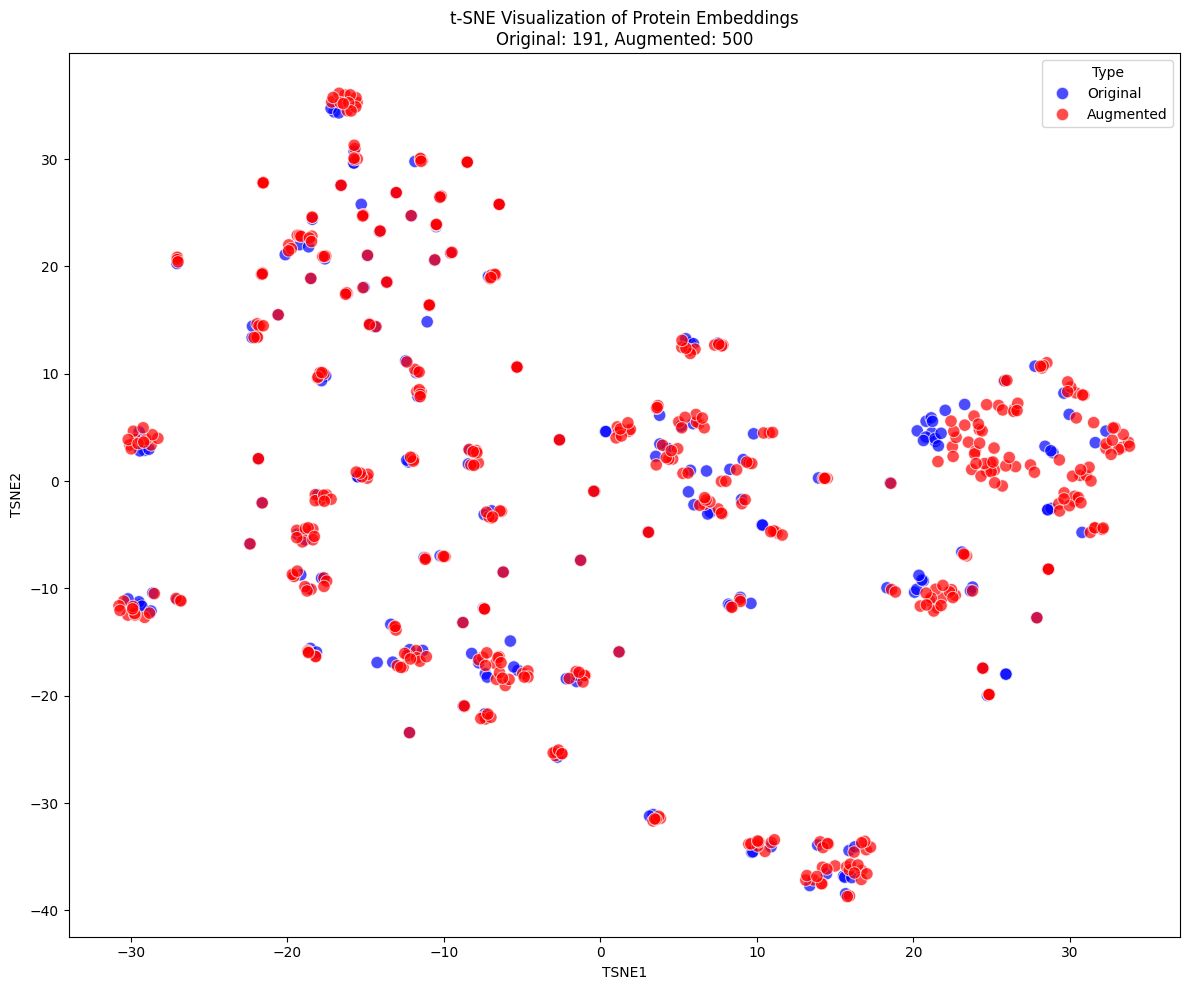

In [25]:
def visualize_protein_embeddings_separate_dfs(df_filtered, augmented_df, device="cpu", model=None, alphabet=None, sample_size=500, random_state=42):
    """
    Visualize protein embeddings by treating:
    - All proteins in df_filtered as Original
    - All proteins with synthetic=True in augmented_df as Augmented

    Using mean pooling across sequence length for each protein.
    """
    import numpy as np
    import pandas as pd
    import torch
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    import seaborn as sns
    import esm

    # Set random seed
    np.random.seed(random_state)
    torch.manual_seed(random_state)

    # Get original proteins from df_filtered
    orig_df = df_filtered.copy()
    # Get synthetic proteins from augmented_df
    aug_df = augmented_df[augmented_df['synthetic'] == True].copy()

    print(f"Original proteins from df_filtered: {len(orig_df)}")
    print(f"Augmented proteins from augmented_df: {len(aug_df)}")

    # Sample if datasets are too large
    if len(orig_df) > sample_size:
        orig_df = orig_df.sample(sample_size, random_state=random_state)

    if len(aug_df) > sample_size:
        aug_df = aug_df.sample(sample_size, random_state=random_state)

    # Combine into one DataFrame for processing
    orig_df['is_original'] = True
    aug_df['is_original'] = False
    df_to_process = pd.concat([orig_df, aug_df])

    print(f"Processing {len(df_to_process)} proteins")

    # Load ESM model if not provided
    if model is None or alphabet is None:
        print("Loading ESM model...")
        model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
        model = model.eval().to(device)

    batch_converter = alphabet.get_batch_converter()

    # Compute embeddings for all proteins
    print("Computing embeddings...")
    embeddings = {}
    labels = []
    sequences = []

    # Process in batches to avoid memory issues
    batch_size = 8
    all_sequences = df_to_process['protein_sequence'].tolist()
    is_original = df_to_process['is_original'].tolist()

    for i in range(0, len(all_sequences), batch_size):
        batch_sequences = all_sequences[i:i+batch_size]
        batch_labels = ["Original" if orig else "Augmented" for orig in is_original[i:i+batch_size]]

        # Prepare batch data
        batch_data = [(f"protein_{j}", seq) for j, seq in enumerate(batch_sequences)]
        _, _, batch_tokens = batch_converter(batch_data)
        batch_tokens = batch_tokens.to(device)

        # Get embeddings
        with torch.no_grad():
            results = model(batch_tokens, repr_layers=[33], return_contacts=False)

        # Store embeddings and labels
        for j, (seq, label) in enumerate(zip(batch_sequences, batch_labels)):
            # Get sequence embedding (averaging across sequence length)
            seq_len = len(seq)
            # Get token embeddings excluding special tokens (1 to seq_len+1)
            token_embeddings = results["representations"][33][j, 1:seq_len+1]
            # Mean pooling across sequence length
            emb = token_embeddings.mean(dim=0).cpu().numpy()
            embeddings[seq] = emb
            labels.append(label)
            sequences.append(seq)

        print(f"Processed {min(i+batch_size, len(all_sequences))}/{len(all_sequences)} sequences")

    # Convert to arrays for TSNE
    embeddings_array = np.array(list(embeddings.values()))

    # Run t-SNE
    print("Running t-SNE dimensionality reduction...")
    tsne = TSNE(n_components=2, random_state=random_state, perplexity=min(30, len(embeddings_array)-1))
    reduced_embeddings = tsne.fit_transform(embeddings_array)

    # Create DataFrame for visualization
    viz_df = pd.DataFrame({
        'TSNE1': reduced_embeddings[:, 0],
        'TSNE2': reduced_embeddings[:, 1],
        'Type': labels,
        'Sequence': sequences
    })

    # Count original and augmented proteins
    orig_count = labels.count("Original")
    aug_count = labels.count("Augmented")
    print(f"Original proteins: {orig_count}")
    print(f"Augmented proteins: {aug_count}")

    # Visualization
    plt.figure(figsize=(12, 10))
    sns.scatterplot(
        data=viz_df,
        x='TSNE1',
        y='TSNE2',
        hue='Type',
        palette={'Original': 'blue', 'Augmented': 'red'},
        alpha=0.7,
        s=80
    )
    plt.title(f't-SNE Visualization of Protein Embeddings\nOriginal: {orig_count}, Augmented: {aug_count}')
    plt.tight_layout()
    plt.show()

    return viz_df, embeddings


viz_df, embeddings = visualize_protein_embeddings_separate_dfs(
    df_filtered,
    augmented_df,
    device="cuda",
    sample_size=500
)

In [26]:
df_filtered.to_csv('filtered_data.csv', index=False)
augmented_df.to_csv('augmented_data.csv', index=False)

In [ ]:
# import pandas as pd
# from sklearn.model_selection import train_test_split

# pet_df = df_filtered[df_filtered["Plastic Type"]=="PET"]
# non_pet_df = df_filtered[df_filtered["Plastic Type"]!="PET"]

# pet_train, pet_test = train_test_split(pet_df, test_size=0.2, random_state=42)
# non_pet_train_val, non_pet_test = train_test_split(non_pet_df, test_size=0.15, random_state=42)
# non_pet_train, non_pet_val = train_test_split(non_pet_train_val, test_size=0.1765, random_state=42)

# train_df = pd.concat([pet_train, non_pet_train])
# val_df = non_pet_val
# test_df = pd.concat([pet_test, non_pet_test])

# train_df.to_csv("training.csv", index=False)
# val_df.to_csv("validation.csv", index=False)
# test_df.to_csv("testing.csv", index=False)


In [28]:
!pip install rdkit-pypi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 71.8 MB/s eta 0:00:00


In [33]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

# Convert SMILES to fingerprints
def smiles_to_fp(smiles_list):
    fps = []
    valid_indices = []

    for i, smiles in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
            fps.append(np.array(fp))
            valid_indices.append(i)
        else:
            # Skip invalid SMILES rather than adding zeros
            print(f"Warning: Invalid SMILES found: {smiles}")

    return np.array(fps), valid_indices

# Cluster SMILES from augmented_df
def cluster_and_split_augmented(augmented_df, n_clusters=10, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    """
    Cluster SMILES from augmented_df and split into train/val/test sets

    Parameters:
    -----------
    augmented_df : pandas DataFrame
        The augmented dataframe containing both original and synthetic proteins
    n_clusters : int
        Number of clusters to create
    train_size, val_size, test_size : float
        Proportions for train/val/test splits (should sum to 1.0)
    random_state : int
        Random seed for reproducibility

    Returns:
    --------
    train_df, val_df, test_df : pandas DataFrames
        The split datasets
    """
    # Verify split proportions
    assert np.isclose(train_size + val_size + test_size, 1.0), "Split proportions must sum to 1.0"

    # Get unique SMILES to cluster (to avoid clustering the same SMILES multiple times)
    unique_smiles = augmented_df["smiles"].unique()
    print(f"Found {len(unique_smiles)} unique SMILES strings")

    # Convert to fingerprints
    fingerprints, valid_indices = smiles_to_fp(unique_smiles)
    valid_smiles = unique_smiles[valid_indices]

    print(f"Generated fingerprints for {len(fingerprints)} valid SMILES")

    # Adjust number of clusters if needed
    n_clusters = min(n_clusters, len(fingerprints))
    print(f"Clustering into {n_clusters} clusters")

    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    clusters = kmeans.fit_predict(fingerprints)

    # Create mapping from SMILES to cluster
    smiles_to_cluster = dict(zip(valid_smiles, clusters))

    # Assign clusters to the original dataframe
    # This step ensures both original and synthetic proteins with the same SMILES
    # go into the same split
    augmented_df = augmented_df.copy()
    augmented_df["cluster"] = augmented_df["smiles"].map(smiles_to_cluster)

    # Handle any rows with invalid SMILES (assign to a dummy cluster)
    if augmented_df["cluster"].isna().any():
        print(f"Warning: {augmented_df['cluster'].isna().sum()} rows with invalid SMILES assigned to dummy cluster")
        augmented_df["cluster"] = augmented_df["cluster"].fillna(-1)

    # Count data points per cluster
    cluster_counts = augmented_df["cluster"].value_counts()
    print(f"Cluster sizes (top 5): {cluster_counts.head()}")

    # Split clusters into train/val/test
    # First split for train vs (val+test)
    val_test_size = val_size + test_size
    train_clusters, val_test_clusters = train_test_split(
        np.unique(augmented_df["cluster"]),
        test_size=val_test_size,
        random_state=random_state
    )

    # Then split val_test into val and test
    val_size_adjusted = val_size / val_test_size
    val_clusters, test_clusters = train_test_split(
        val_test_clusters,
        test_size=(1 - val_size_adjusted),
        random_state=random_state
    )

    # Create the splits
    train_df = augmented_df[augmented_df["cluster"].isin(train_clusters)]
    val_df = augmented_df[augmented_df["cluster"].isin(val_clusters)]
    test_df = augmented_df[augmented_df["cluster"].isin(test_clusters)]

    # Print statistics
    print(f"\nSplit statistics:")
    print(f"Train: {len(train_df)} rows with {train_df['smiles'].nunique()} unique SMILES")
    print(f"Val: {len(val_df)} rows with {val_df['smiles'].nunique()} unique SMILES")
    print(f"Test: {len(test_df)} rows with {test_df['smiles'].nunique()} unique SMILES")

    # Also print synthetic vs original distribution
    if 'synthetic' in augmented_df.columns:
        for name, df in zip(['Train', 'Val', 'Test'], [train_df, val_df, test_df]):
            synthetic_count = df['synthetic'].sum() if 'synthetic' in df.columns else 0
            orig_count = len(df) - synthetic_count
            print(f"{name}: {orig_count} original, {synthetic_count} synthetic")

    return train_df, val_df, test_df



In [34]:
train_df, val_df, test_df = cluster_and_split_augmented(
    augmented_df,
    n_clusters=20,
    train_size=0.7,
    val_size=0.15,
    test_size=0.15,
    random_state=42
)

# Save the splits
train_df.to_csv("augmented_train.csv", index=False)
val_df.to_csv("augmented_val.csv", index=False)
test_df.to_csv("augmented_test.csv", index=False)

Found 35 unique SMILES strings
Generated fingerprints for 30 valid SMILES
Clustering into 20 clusters


[16:11:34] Explicit valence for atom # 14 N, 4, is greater than permitted
[16:11:34] Explicit valence for atom # 31 N, 4, is greater than permitted
[16:11:34] Explicit valence for atom # 31 N, 4, is greater than permitted
[16:11:34] Explicit valence for atom # 14 N, 4, is greater than permitted
[16:11:34] Explicit valence for atom # 40 N, 4, is greater than permitted


Cluster sizes (top 5): cluster
 16.0    3111
 4.0     1989
 8.0      765
-1.0      714
 5.0      510
Name: count, dtype: int64

Split statistics:
Train: 3111 rows with 17 unique SMILES
Val: 612 rows with 9 unique SMILES
Test: 6018 rows with 9 unique SMILES
Train: 61 original, 3050 synthetic
Val: 12 original, 600 synthetic
Test: 118 original, 5900 synthetic


Unique SMILES - Train: 17, Val: 9, Test: 9
Generated fingerprints for 30 valid SMILES
Running t-SNE with perplexity=30...


[16:13:13] Explicit valence for atom # 14 N, 4, is greater than permitted
[16:13:13] Explicit valence for atom # 31 N, 4, is greater than permitted
[16:13:13] Explicit valence for atom # 31 N, 4, is greater than permitted
[16:13:13] Explicit valence for atom # 14 N, 4, is greater than permitted
[16:13:13] Explicit valence for atom # 40 N, 4, is greater than permitted


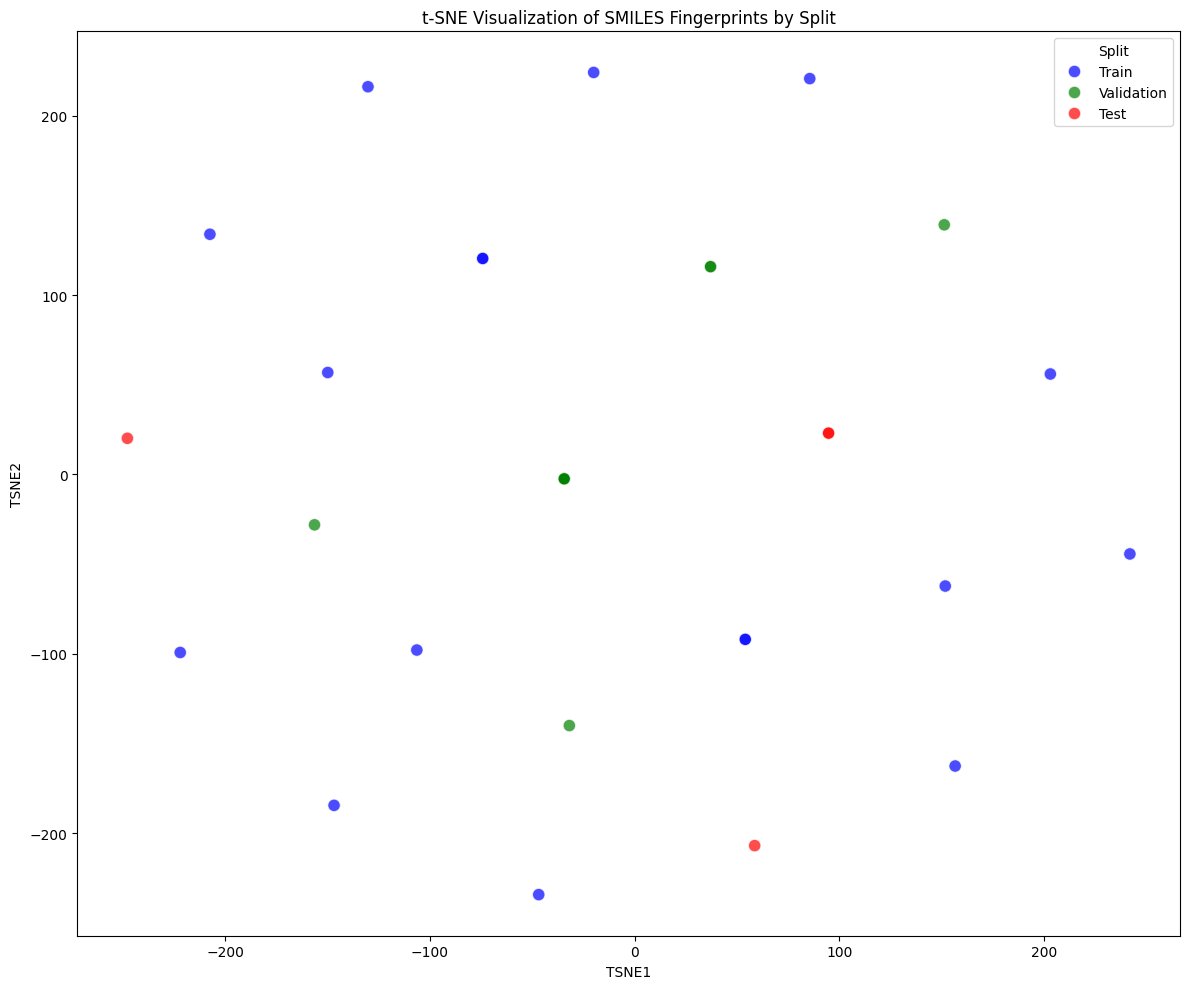


Similarity analysis (sample of molecules):
Train-Val average max similarity: 0.6244
Train-Test average max similarity: 0.5257
Val-Test average max similarity: 0.6143
Unique SMILES - Train: 17, Val: 9, Test: 9
Generated fingerprints for 30 valid SMILES
Running t-SNE with perplexity=30...


[16:13:14] Explicit valence for atom # 14 N, 4, is greater than permitted
[16:13:14] Explicit valence for atom # 31 N, 4, is greater than permitted
[16:13:14] Explicit valence for atom # 31 N, 4, is greater than permitted
[16:13:14] Explicit valence for atom # 14 N, 4, is greater than permitted
[16:13:14] Explicit valence for atom # 40 N, 4, is greater than permitted


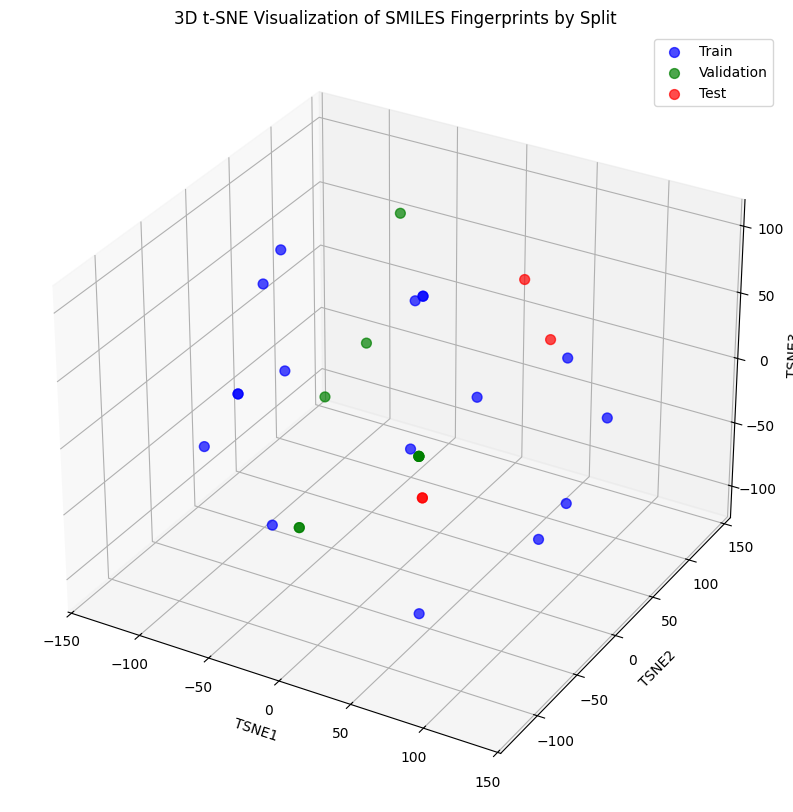


Similarity analysis (sample of molecules):
Train-Val average max similarity: 0.6806
Train-Test average max similarity: 0.5318
Val-Test average max similarity: 0.6555


In [35]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_smiles_splits(train_df, val_df, test_df, random_state=42, perplexity=30, n_components=2):
    """
    Visualize SMILES from train/val/test splits using t-SNE.

    Parameters:
    -----------
    train_df, val_df, test_df : pandas DataFrames
        The split datasets
    random_state : int
        Random seed for reproducibility
    perplexity : int
        Perplexity parameter for t-SNE
    n_components : int
        Number of components for t-SNE (2 or 3)
    """
    # Get unique SMILES from each split
    train_smiles = train_df['smiles'].unique()
    val_smiles = val_df['smiles'].unique()
    test_smiles = test_df['smiles'].unique()

    print(f"Unique SMILES - Train: {len(train_smiles)}, Val: {len(val_smiles)}, Test: {len(test_smiles)}")

    # Combine all SMILES
    all_smiles = np.concatenate([train_smiles, val_smiles, test_smiles])
    split_labels = np.concatenate([
        np.full(len(train_smiles), 'Train'),
        np.full(len(val_smiles), 'Validation'),
        np.full(len(test_smiles), 'Test')
    ])

    # Generate fingerprints
    fps = []
    valid_indices = []

    for i, smiles in enumerate(all_smiles):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
            fps.append(np.array(fp))
            valid_indices.append(i)
        else:
            print(f"Warning: Invalid SMILES found: {smiles}")

    fps_array = np.array(fps)
    valid_labels = split_labels[valid_indices]

    print(f"Generated fingerprints for {len(fps_array)} valid SMILES")

    # Run t-SNE
    print(f"Running t-SNE with perplexity={perplexity}...")
    perplexity = min(perplexity, len(fps_array) - 1)  # Adjust perplexity if needed
    tsne = TSNE(n_components=n_components, random_state=random_state, perplexity=perplexity)
    reduced_fps = tsne.fit_transform(fps_array)

    # Create DataFrame for visualization
    if n_components == 2:
        viz_df = pd.DataFrame({
            'TSNE1': reduced_fps[:, 0],
            'TSNE2': reduced_fps[:, 1],
            'Split': valid_labels
        })

        # Plot
        plt.figure(figsize=(12, 10))
        sns.scatterplot(
            data=viz_df,
            x='TSNE1',
            y='TSNE2',
            hue='Split',
            palette={'Train': 'blue', 'Validation': 'green', 'Test': 'red'},
            alpha=0.7,
            s=80
        )
        plt.title('t-SNE Visualization of SMILES Fingerprints by Split')
        plt.tight_layout()

    else:  # 3D plot
        from mpl_toolkits.mplot3d import Axes3D

        viz_df = pd.DataFrame({
            'TSNE1': reduced_fps[:, 0],
            'TSNE2': reduced_fps[:, 1],
            'TSNE3': reduced_fps[:, 2],
            'Split': valid_labels
        })

        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')

        for label, color in zip(['Train', 'Validation', 'Test'], ['blue', 'green', 'red']):
            subset = viz_df[viz_df['Split'] == label]
            ax.scatter(
                subset['TSNE1'],
                subset['TSNE2'],
                subset['TSNE3'],
                label=label,
                c=color,
                alpha=0.7,
                s=50
            )

        ax.set_xlabel('TSNE1')
        ax.set_ylabel('TSNE2')
        ax.set_zlabel('TSNE3')
        ax.legend()
        plt.title('3D t-SNE Visualization of SMILES Fingerprints by Split')

    plt.show()

    # Also calculate and print overlap metrics
    # Count how many similar fingerprints exist across splits
    from sklearn.metrics.pairwise import cosine_similarity

    # Get indices for each split
    train_indices = np.where(valid_labels == 'Train')[0]
    val_indices = np.where(valid_labels == 'Validation')[0]
    test_indices = np.where(valid_labels == 'Test')[0]

    # Calculate cosine similarity for a sample of molecules across splits
    # (full matrices would be too large)
    sample_size = min(100, min(len(train_indices), len(val_indices), len(test_indices)))

    if sample_size > 0:
        train_sample = np.random.choice(train_indices, sample_size, replace=False)
        val_sample = np.random.choice(val_indices, sample_size, replace=False)
        test_sample = np.random.choice(test_indices, sample_size, replace=False)

        # Calculate similarities
        train_val_sim = cosine_similarity(fps_array[train_sample], fps_array[val_sample])
        train_test_sim = cosine_similarity(fps_array[train_sample], fps_array[test_sample])
        val_test_sim = cosine_similarity(fps_array[val_sample], fps_array[test_sample])

        # Calculate highest similarity for each pair
        train_val_max = np.max(train_val_sim, axis=1)
        train_test_max = np.max(train_test_sim, axis=1)
        val_test_max = np.max(val_test_sim, axis=1)

        print("\nSimilarity analysis (sample of molecules):")
        print(f"Train-Val average max similarity: {np.mean(train_val_max):.4f}")
        print(f"Train-Test average max similarity: {np.mean(train_test_max):.4f}")
        print(f"Val-Test average max similarity: {np.mean(val_test_max):.4f}")

    return viz_df


viz_df = visualize_smiles_splits(train_df, val_df, test_df)

# # For 3D visualization:
viz_df_3d = visualize_smiles_splits(train_df, val_df, test_df, n_components=3)